## AB-Тестирование изменений интерфейса
Необходимо подтвердить или опровергнуть наличие изменений в поведении между группами пользователей по количеству пользовательских кликов в зависимости от тестируемого изменения.

#### Импорты

In [58]:
import pandas as pd
import numpy as np
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.sandbox.stats.multicomp import multipletests 

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Функции

In [2]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

#### Данные
exp/control - новый/старый интерфейс

n_queries - количество запросов

n_clicks - количество кликов за n_queries

n_nonclk_queries - количество запросов без кликов

In [3]:
data = pd.read_csv('../data/ab_browser_test.csv',',')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


#### Анализ результатов

Разница по количеству кликов между группами в процентах

In [4]:
exp_click_sum = data[data.slot == 'exp']['n_clicks'].sum()
con_click_sum = data[data.slot == 'control']['n_clicks'].sum()

round(((exp_click_sum-con_click_sum)/con_click_sum)*100,3)

1.614

Бутстрапированный доверительный интервал разности медиан

In [5]:
exp_meds = list(map(np.median, get_bootstrap_samples(data[data.slot == 'exp']['n_clicks'].values, 1000)))
con_meds = list(map(np.median, get_bootstrap_samples(data[data.slot == 'control']['n_clicks'].values, 1000)))
delta_meds = list(map(lambda x: x[0] - x[1], zip(exp_meds, con_meds)))
stat_intervals(delta_meds, 0.05)

array([ 1.,  1.])

Бутстрапированный доверительный интервал разности медиан средних значений

In [6]:
exp_means = list(map(np.mean, get_bootstrap_samples(data[data.slot == 'exp']['n_clicks'].values, 1000)))
con_means = list(map(np.mean, get_bootstrap_samples(data[data.slot == 'control']['n_clicks'].values, 1000)))
delta_means = list(map(lambda x: x[0] - x[1], zip(exp_means, con_means)))
stat_intervals(delta_means, 0.05)

array([ 0.19164947,  0.40963167])

Проверка предположений о том, что среднее значение в контрольной выборке распределено нормально и оценка дисперсии распределена по Хи квадрат (n-1)

In [99]:
np.random.seed(0)

con_samples = get_bootstrap_samples(data[data.slot == 'control']['n_clicks'].values, 500)
con_means = list(map(np.mean,con_samples))
con_chi_squared = list(map(lambda x: sum(np.abs(x - x.mean()))**2,con_samples))

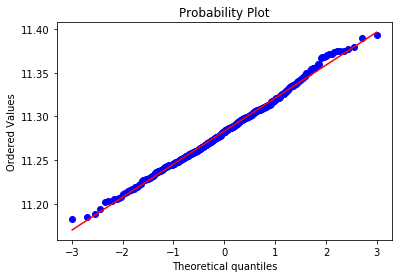

In [101]:
scipy.stats.probplot(con_means, dist='norm',plot=pylab)
pylab.show()
#R2 = 0.99797483646042018

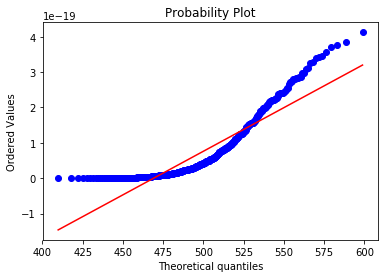

In [9]:
scipy.stats.probplot(con_chi_squared, dist='chi2',sparams=(len(con_chi_squared)-1),plot=pylab)
pylab.show()
#R2=0.91011654314044532

Критерий Мана-Уитни на обширном классе распределений является более эффективным чем T-критерий, а также не требует параметрических предположений.

In [31]:
control = data[data.slot =='control'].groupby('userID', as_index=False)[['n_clicks']].sum()
exp = data[data.slot =='exp'].groupby('userID', as_index=False)[['n_clicks']].sum()

In [39]:
stats.mannwhitneyu(control.n_clicks.values, exp.n_clicks.values)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Определение браузера с наиболее выраженным отличием по количеству кликов между группами пользователей.

In [60]:
data.browser.unique()

array(['Browser #2', 'Browser #4', 'Browser #14', 'Browser #17',
       'Browser #20', 'Browser #22'], dtype=object)

In [67]:
browser_df = pd.DataFrame(columns=['Browser','statistic','p_value'])
for browser in data.browser.unique():
    res = stats.mannwhitneyu(data[(data.browser ==browser) & (data.slot == 'exp')]['n_clicks'].values, 
                   data[(data.browser == browser) & (data.slot == 'control')]['n_clicks'].values)
    browser_df = browser_df.append({'Browser':browser,'statistic':res[0],
                                    'p_value':res[1]},  ignore_index=True)

Применяем поправку Холма-Бонферрони

In [75]:
reject, p_corrected, a1, a2 = multipletests(browser_df.p_value, 
                                            alpha = 0.05, 
                                            method = 'holm') 
browser_df['p_corrected'] = p_corrected
browser_df['reject'] = reject

In [76]:
browser_df

,Browser,statistic,p_value,p_corrected,reject
0,Browser #2,1.522573e+09,0.027244,0.136219,False
1,Browser #4,3.072448e+09,0.407606,0.815212,False
2,Browser #14,8.069847e+08,0.000000,0.000000,True
3,Browser #17,1.313897e+08,0.037401,0.149602,False
4,Browser #20,1.437918e+08,0.453667,0.815212,False
5,Browser #22,2.547598e+09,0.257406,0.772217,False


Оценка доли запросов, в которых пользователь не разу не кликнул

In [97]:
browser_slot_df = pd.DataFrame(columns=['Browser','slot','nonclk_prcnt'])
for browser in data.browser.unique():
    for slot in data.slot.unique():
        nonclk_q = data[(data.browser ==browser) & (data.slot == slot)][['n_nonclk_queries']].sum()[0]
        all_q = data[(data.browser ==browser) & (data.slot == slot)][['n_queries']].sum()[0]
        prcnt = (nonclk_q / all_q)*100
        browser_slot_df = browser_slot_df.append({'Browser':browser,'slot':slot,'nonclk_prcnt':prcnt},  
                                                 ignore_index=True)

In [98]:
browser_slot_df

,Browser,slot,nonclk_prcnt
0,Browser #2,exp,44.982747
1,Browser #2,control,45.962747
2,Browser #4,exp,45.142942
3,Browser #4,control,46.970930
4,Browser #14,exp,43.755617
5,Browser #14,control,57.590411
6,Browser #17,exp,36.937413
7,Browser #17,control,36.299367
8,Browser #20,exp,38.977376
9,Browser #20,control,40.540485


#### Вывод
Изменение в web интерфейсе привело к значимому увеличению пользовательских кликов, а также сократило долю запросов, в которых пользователь не разу не кликнул, для браузера №14.